In [1]:
import logging
import tensorflow as tf


GPU_FROM = 0
GPU_TO = 1

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-21 16:40:08.397077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 16:40:08.542086: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 16:40:08.579337: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 16:40:09.236533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import string
import html
import tensorflow_datasets as tfds

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

gap = 3
len = 100

punc_mapping = {ord(x):x for x in string.punctuation}
entity_mapping = {f" ?{k}": v for k, v in html.entities.html5.items() if k.endswith(";") and v in string.punctuation}
punc_mapping = {f' ?&?#?{k};': v for k, v in punc_mapping.items()}

train, test = tfds.load('ag_news_subset', split="train"), tfds.load('ag_news_subset', split="test")

def unescape(text):
    for match, replace in punc_mapping.items():
        text = tf.strings.regex_replace(text, match, replace)
    for match, replace in entity_mapping.items():#
        text = tf.strings.regex_replace(text, match, replace)
    return text

def join_title_desc(text_dict):
    return text_dict['title'] + ' ' + text_dict['description']

def remove_space(text):
    return tf.strings.reduce_join(tf.strings.strip(tf.strings.split(text)), axis=-1)

def space_after_letter(letter):
    def replacer(x):
        x = tf.strings.regex_replace(x, f"({letter})", r"\1 ") # add whitespace back in after every letter e
        return x
    return replacer

train = train.map(join_title_desc).map(unescape).map(remove_space)
test = test.map(join_title_desc).map(unescape).map(remove_space)

for x in train.take(1):
    print(x)

/home/ma/a/al3615/tf_210/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-21 16:40:10.797799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 16:40:11.487679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


tf.Tensor(b"AMDDebutsDual-CoreOpteronProcessorAMD'snewdual-coreOpteronchipisdesignedmainlyforcorporatecomputingapplications,includingdatabases,Webservices,andfinancialtransactions.", shape=(), dtype=string)


2023-02-21 16:40:12.379878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [3]:

def generate_labels(text):
    text = tf.strings.substr(text, 0, len)
    text = tf.strings.lower(text)
    encoder_in = text
    encoder_out = tf.strings.regex_replace(text, r"[^e]", "1") # 1 indicates character
    encoder_out = tf.strings.regex_replace(encoder_out, r"e", "2") # 2 indicates space
    encoder_out = tf.strings.bytes_split(encoder_out)
    encoder_out = tf.strings.to_number(encoder_out)
    encoder_out = tf.pad(encoder_out, [[0,len-tf.shape(encoder_out)[0]]])

    return (encoder_in, None), encoder_out

train = train.map(generate_labels)
val = test.map(generate_labels)
for x in train.take(1):
    print(x)

((<tf.Tensor: shape=(), dtype=string, numpy=b"amddebutsdual-coreopteronprocessoramd'snewdual-coreopteronchipisdesignedmainlyforcorporatecomputinga">, None), <tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>)


2023-02-21 16:40:12.882984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=len,
    standardize="lower",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train.take(1000).map(lambda x,y: x[0]))
tokenizer.get_vocabulary()

2023-02-21 16:40:16.010553: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


['',
 '[UNK]',
 'e',
 'a',
 't',
 's',
 'o',
 'i',
 'n',
 'r',
 'l',
 'd',
 'h',
 'c',
 'u',
 'p',
 'm',
 'f',
 'g',
 'b',
 'y',
 'w',
 'k',
 'v',
 '-',
 ',',
 '.',
 "'",
 '(',
 ')',
 '0',
 'x',
 'j',
 '2',
 '1',
 'q',
 '&',
 ':',
 'z',
 '4',
 '3',
 '\\',
 '5',
 '"',
 '<',
 '>',
 '/',
 '7',
 '6',
 '$',
 '8',
 '9',
 ';',
 '?',
 '=',
 '#',
 '!',
 '*']

In [5]:
def inverse_xor(x,y):
    return (1-x)*(1-y)+x*y

inverse_xor(tf.constant([0,0,1,1]),tf.constant([0,1,0,1]))

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 0, 0, 1], dtype=int32)>

In [6]:
for x in train.batch(1).take(1):
    print(x)
    str_input = x[0][0]
    tokens = tokenizer(str_input)
    print(tokens)
    e_encode = 2
    space_label = 2
    space_tokens = tf.where(tokens == e_encode, 1, 0) # Just happen to know e tokenizes to 2 - messy af
    # Look at labels and ensure that when we have a space label '2' we also have a token for e (2)
    labels = tf.cast(x[1], space_tokens.dtype)
    labels = tf.where(labels == space_label, 1, 0)
    result = tf.reduce_all(tf.cast(inverse_xor(space_tokens, labels),"bool"))
    print(f"Match between token of space char, {e_encode}, and space label, {space_label} | {result.numpy()}")

((<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"amddebutsdual-coreopteronprocessoramd'snewdual-coreopteronchipisdesignedmainlyforcorporatecomputinga"],
      dtype=object)>, None), <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)>)
tf.Tensor(
[[ 3 16 11 11  2 19 14  4  5 11 14  3 10 24 13  6  9  2  6 15  4  2  9  6
   8 15  9  6 13  2  5  5  6  9  3 16 11 27  5  8  2 21 11 14  3 10 24 13
   6  9  2  6 15  4  2  9  6  8 13 12  7 15  7  5 11  2  5  7 18  8  2 11
  16  3  7  8 10 20 17  6  9 13  6  9 15  6  9  3  4 

2023-02-21 16:40:16.590978: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
D_MODEL = 512

model = SpaceSegmentationTransformer(
    num_layers=2,
    d_model=D_MODEL,
    num_attention_heads=3,
    seq_len=100,
    dff=1028,
    input_tokenizer=tokenizer,
    dropout_rate=0.1,
    num_classes=3,
)

In [8]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=200):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return 2* tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0.),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [9]:
train_ds = train.shuffle(100).batch(8)
val_ds = val.batch(8)
EPOCHS=15
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_space_f1",
        patience=EPOCHS//4,
        mode="max",
        restore_best_weights=True
    )
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, steps_per_epoch=1000)

Epoch 1/15
   7/1000 [..............................] - ETA: 21s - loss: 2.6583 - sparse_categorical_accuracy: 0.6836 - space_precision: 0.1414 - space_recall: 0.2972 - space_f1: 0.1916 - char_precision: 0.8942 - char_recall: 0.7303 - char_f1: 0.8039   

2023-02-21 16:40:21.720943: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1000/1000 [==============================] - 39s 35ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.9656 - space_precision: 0.9223 - space_recall: 0.7476 - space_f1: 0.8258 - char_precision: 0.9688 - char_recall: 0.9920 - char_f1: 0.9803 - val_loss: 2.0146e-05 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 0.9986 - val_char_recall: 1.0000 - val_char_f1: 0.9993
Epoch 2/15
1000/1000 [==============================] - 33s 33ms/step - loss: 4.9665e-04 - sparse_categorical_accuracy: 0.9999 - space_precision: 0.9993 - space_recall: 0.9994 - space_f1: 0.9994 - char_precision: 0.9988 - char_recall: 0.9999 - char_f1: 0.9993 - val_loss: 2.3061e-06 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 0.9986 - val_char_recall: 1.0000 - val_char_f1: 0.9993
Epoch 3/15
1000/1000 [=============================

In [10]:
model.evaluate(val_ds)

950/950 [==============================] - 13s 13ms/step - loss: 2.0146e-05 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 0.9986 - char_recall: 1.0000 - char_f1: 0.9993


[2.0145636881352402e-05,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9986254572868347,
 1.0,
 0.9993122220039368]

2023-02-21 16:42:51.021764: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


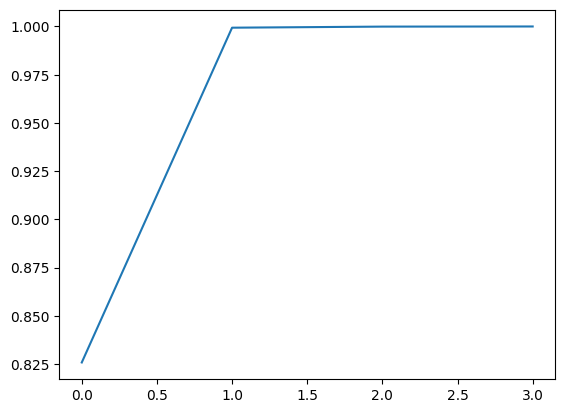

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['space_f1'])

In [12]:
preds = model([("dunningkruger", "feeeee", "eeeee", "e"*100, "thequickbrownfoxjumpedoverthelazydog"),(None,None, None)])
tf.argmax(preds, axis=-1)

<tf.Tensor: shape=(5, 100), dtype=int64, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [13]:
preds

<tf.Tensor: shape=(5, 100, 3), dtype=float32, numpy=
array([[[1.27028528e-13, 9.99999881e-01, 1.15808710e-07],
        [1.07958117e-13, 9.99999762e-01, 1.89665528e-07],
        [1.08071843e-13, 9.99999762e-01, 1.88801977e-07],
        ...,
        [1.00001597e-13, 9.99999762e-01, 2.40522979e-07],
        [9.99447785e-14, 9.99999762e-01, 2.40438141e-07],
        [9.98883593e-14, 9.99999762e-01, 2.40393916e-07]],

       [[1.11731920e-13, 9.99999881e-01, 1.68210263e-07],
        [1.75156528e-10, 1.95931032e-04, 9.99804080e-01],
        [1.74880194e-10, 1.95554385e-04, 9.99804437e-01],
        ...,
        [1.12316738e-13, 9.99999881e-01, 1.75728587e-07],
        [1.12240282e-13, 9.99999881e-01, 1.76215593e-07],
        [1.12273682e-13, 9.99999881e-01, 1.76153762e-07]],

       [[1.03240563e-13, 9.99999762e-01, 2.11720405e-07],
        [1.03278571e-13, 9.99999762e-01, 2.11830468e-07],
        [1.03281919e-13, 9.99999762e-01, 2.11873896e-07],
        ...,
        [1.12102290e-13, 9.9999988

# Confirming that distribution of embeddings for space letter are different from everything else

## Using UMAP

In [14]:
import string
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(
    n_neighbors = 2,
    min_dist = 0.1,
    metric="manhattan"
)
scaler = StandardScaler()

In [15]:
import pandas as pd
letters = list(string.ascii_lowercase)
preds = model.encoder.pos_embedding(tokenizer(letters))
assert tf.reduce_all(preds[:-1,1:,:]==preds[1:,1:,:]), "Check positional encodings are all that is left after first index"
assert tf.logical_not(tf.reduce_any(preds[:-1,0,:]==preds[1:,0,:])), "Check 1st embeddings are all different"
embeddings = preds[:,0,:].numpy()
to_visualize = pd.DataFrame(embeddings)
to_visualize['letter'] = letters
embeddings.shape

(26, 512)

In [16]:
scaled = scaler.fit_transform(embeddings)
reduced_embeddings = reducer.fit_transform(scaled)

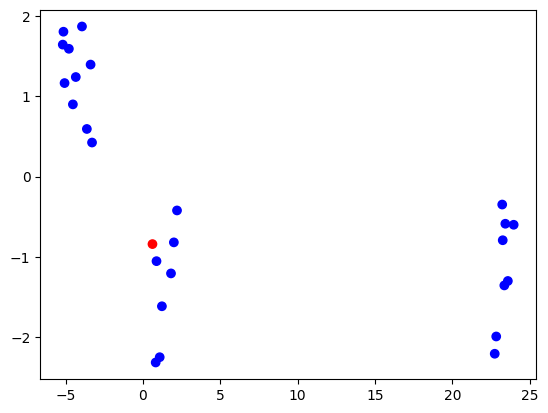

In [17]:
plt.scatter(
    reduced_embeddings[:,0],
    reduced_embeddings[:,1],
    c=['r' if x == "e" else "b" for x in to_visualize['letter']]
)

## Using dot product

In [18]:
import numpy as np
dots = (embeddings@embeddings.T)
norms = (embeddings**2).sum(axis=-1)**0.5
norm1, norm2 = np.meshgrid(norms, norms)
cosines = dots/(norm1*norm2)
angles = np.arccos(cosines)

/tmp/ipykernel_2678738/4084122731.py:6: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosines)


In [19]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

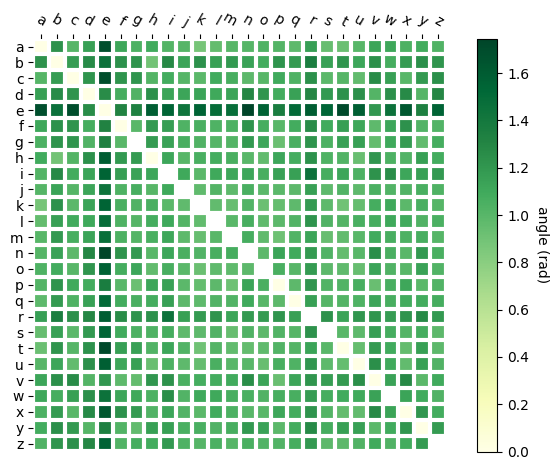

In [20]:
fig, ax = plt.subplots()

im, cbar = heatmap(angles, letters, letters, ax=ax,
                   cmap="YlGn", cbarlabel="angle (rad)")
# texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()
